## Binary Classifier
Homework 1  
ECSE 552  
Gian Favero and Mohamed Mohamed  
February 5th, 2024

### Objectives

The object of this notebook is to construct and train a binary classifier network on simulated data of the form:

- Label = 0:
  $$ x_1 = r\cos(t) $$
  $$ x_2 = r\sin(t) $$

- Label = 1:
  $$ x_1 = (r + 5)\cos(t) $$
  $$ x_2 = (r + 5)\sin(t) $$

- $ r \sim \mathcal{N}(0,1) $, $ t \sim \text{Uniform}(0, 2\pi) $

For simplification, the network has some constraints:

- The neural network has one hidden layer with under 35 units
- The hidden layer has a ReLU activation function

### Getting Started

We begin by importing the necessary libraries for this implementation. For this task we will use NumPy and PyTorch (and some scikit-learn) to create the data, create the model, and train the model. In addition, matplotlib will be used for visualizations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import KFold

# Hide warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seed
np.random.seed(0)

### Creating the Data

The data for this experiment will be simulated using the implementation discussed prior. We will create a balanced dataset of 9000 training samples (including 1000 validation samples) and 1000 test samples.

In [2]:
# Create the training data
X = []
Y = []
for i in range(10000):
    r = np.random.normal(0, 1)
    t = np.random.uniform(0, 2*np.pi)

    if i >= 4000:
        X += [r * np.cos(t), r * np.sin(t)]
        Y.append(0)
    else:
        X += [(r + 5) * np.cos(t), (r + 5) * np.sin(t)]
        Y.append(1)

X = np.array(X).reshape(-1, 2)
Y = np.array(Y).reshape(-1, 1)

# Convert the numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Create a TensorDataset
dataset = TensorDataset(X_tensor, Y_tensor)

# Split the data into training and test sets
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [9000, 1000])

Text(0.5, 1.0, 'Test set')

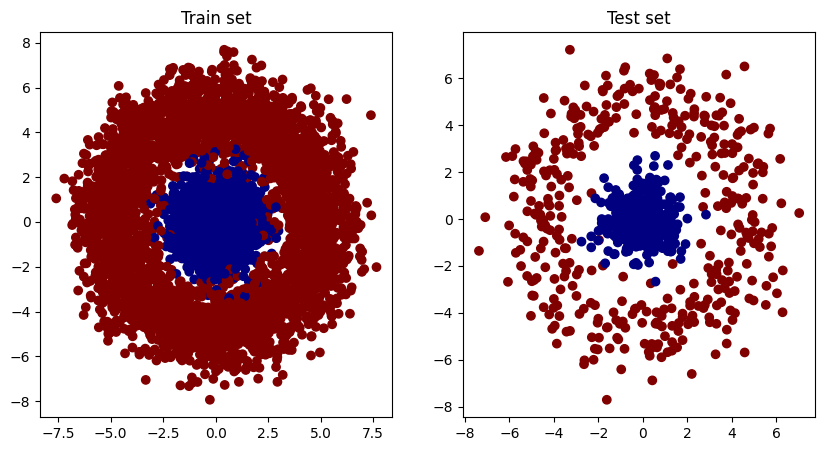

In [3]:
def plot_dataset(dataset):
    X = []
    Y = []
    for x, y in dataset:
        X.append(x.numpy())
        Y.append(y.numpy())

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

trainx, trainy = plot_dataset(train_dataset)
testx, testy = plot_dataset(test_dataset)

# Plot the data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(trainx[:, 0], trainx[:, 1], c=trainy, cmap='jet')
axs[0].set_title('Train set')
axs[1].scatter(testx[:, 0], testx[:, 1], c=testy, cmap='jet')
axs[1].set_title('Test set')

### Creating the Classifier(s)

Given the variability in network, we will define a random grid search over a few key hyperparameters to determine the best achievable performance.

In [4]:
# Random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

hyperparameters = {
    'learning_rate' : np.random.uniform(0.0001, 0.1, 5),
    'batch_size' : [32, 64, 128],
    'hidden_nodes' : np.random.randint(1, 35, 5),
}

def build_hyperparams(hyperparameters: dict, num_models: int=10):
    """
    Builds a list of hyperparameter sets using random combinations of individual hyperparameters.

    Args:
        hyperparameters (dict): A dictionary of hyperparameters
        num_models (int): The number of models to build

    Returns:
        A list of hyperparameter sets
    """
    # Create num_models hyperparameter combinations
    hyperparameter_combinations = []
    for i in range(num_models):
        hyperparameter_combinations.append({
            'learning_rate' : np.random.choice(hyperparameters['learning_rate']),
            'batch_size' : np.random.choice(hyperparameters['batch_size']),
            'hidden_nodes' : np.random.choice(hyperparameters['hidden_nodes'])
        })

    return hyperparameter_combinations

The classifier model itself has one hidden layer with a ReLU activation function. The output layer will conveniently use a sigmoid activation function for thresholding between 0 and 1 for this binary classification task. Followingly, a binary cross entropy loss function will be backpropagated through the network to update the weights upon each minibatch iteration. As a reminder, the input layer is of 2D.

To create the networks, we will define a ```PyTorch.nn.module``` subclass that is initialized with the hyperparameter sets.

In [5]:
class BinaryClassifier(nn.Module):
    def __init__(self, hidden_nodes: int):
        """
        A binary classifier with a single hidden layer.
        """
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(2, hidden_nodes)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_nodes, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

### Hyperparameter Tuning

We are now ready to define a training loop and determine an effective hyperparameter set for the model. An Adam optimizer is implemented to conduct gradient descent more efficiently.

We perform a 4 fold cross validation for each model. Out of the 9000 training samples, 1000 are set aside for validation at each inner loop (non-overlapping). The average validation accuracy over each fold is reported for model selection. We will store the best model and then re-train on the full training set to report its loss/accuracy curves before evaluating on the test set.

In [6]:
# Random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

hyperparameters = build_hyperparams(hyperparameters, 10)
print(hyperparameters)

best_accuracy = 0
best_hyper_id = 0

# Create a DataLoader for the training set
for id, hyperparameter in enumerate(hyperparameters):
    n_splits = 4
    kf = KFold(n_splits=n_splits, shuffle=True)

    model = BinaryClassifier(hyperparameter['hidden_nodes'])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=hyperparameter['learning_rate'])

    val_accuracy = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
        # Get the train and val subsets
        train_subset = Subset(train_dataset, train_idx)
        val_subset = Subset(train_dataset, val_idx)
        
        # Create a DataLoader for the training set
        train_loader = DataLoader(train_subset, batch_size=int(hyperparameter['batch_size']), shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=int(hyperparameter['batch_size']), shuffle=True)

        # Train the model
        for epoch in range(10):
            model.train()
            for batch in train_loader:
                # Get the inputs and labels
                inputs, labels = batch

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate the model on the validation set (once per fold)
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                # Get the inputs and labels
                inputs, labels = batch

                # Forward pass
                outputs = model(inputs)
                
                # Calculate the loss
                loss = criterion(outputs, labels)

                # Calculate the accuracy
                predicted = torch.round(outputs)
                correct = (predicted == labels).sum().item()
                total = len(labels)
                accuracy = correct / total

                val_accuracy.append(accuracy)

    # Calculate the average validation accuracy
    val_accuracy = np.mean(val_accuracy)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_hyper_id = id
    
    print(f'Hyperparameter set {id} - Validation accuracy: {val_accuracy}')

# Print the best hyperparameters
print(f'Best hyperparameter set: {best_hyper_id}')
print(f'Best validation accuracy: {best_accuracy}')
print(f'Best hyperparameters: {hyperparameters[best_hyper_id]}')

[{'learning_rate': 0.042423114453956585, 'batch_size': 64, 'hidden_nodes': 22}, {'learning_rate': 0.05453382998139, 'batch_size': 64, 'hidden_nodes': 25}, {'learning_rate': 0.06031606126955723, 'batch_size': 32, 'hidden_nodes': 22}, {'learning_rate': 0.05492646904233975, 'batch_size': 32, 'hidden_nodes': 7}, {'learning_rate': 0.07154741770060472, 'batch_size': 128, 'hidden_nodes': 22}, {'learning_rate': 0.07154741770060472, 'batch_size': 64, 'hidden_nodes': 24}, {'learning_rate': 0.05492646904233975, 'batch_size': 64, 'hidden_nodes': 25}, {'learning_rate': 0.05453382998139, 'batch_size': 32, 'hidden_nodes': 25}, {'learning_rate': 0.05492646904233975, 'batch_size': 128, 'hidden_nodes': 25}, {'learning_rate': 0.05492646904233975, 'batch_size': 64, 'hidden_nodes': 25}]
Hyperparameter set 0 - Validation accuracy: 0.9917534722222222
Hyperparameter set 1 - Validation accuracy: 0.9900390625000001
Hyperparameter set 2 - Validation accuracy: 0.9907570422535211
Hyperparameter set 3 - Validation 

### Evaluation

Now that we have an effective hyperparameter set for the task, we will re-train a classifier on the full training set and then evaluate on the held out test set before conducting analysis.

In [7]:
model_best = BinaryClassifier(hyperparameters[best_hyper_id]['hidden_nodes'])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=int(hyperparameters[best_hyper_id]['batch_size']), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=int(hyperparameters[best_hyper_id]['batch_size']), shuffle=True)

# Train the model_best
criterion = nn.BCELoss()
optimizer = optim.Adam(model_best.parameters(), lr=hyperparameters[best_hyper_id]['learning_rate'])

# Store the epoch training and test losses
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(50):
    # Store the epoch training and test losses
    epoch_train_losses = []
    epoch_test_losses = []
    epoch_test_accuracies = []

    # Evaluate the model_best on the test set and store epoch losses
    model_best.eval()
    with torch.no_grad():
        for batch in test_loader:
            # Get the inputs and labels
            inputs, labels = batch

            # Forward pass
            outputs = model_best(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, labels)

            # Calculate the accuracy
            predicted = torch.round(outputs)
            correct = (predicted == labels).sum().item()
            total = len(labels)
            accuracy = correct / total

            # Store the epoch test loss and accuracy
            epoch_test_losses.append(loss.item())
            epoch_test_accuracies.append(accuracy)

    model_best.train()
    for batch in train_loader:
        # Get the inputs and labels
        inputs, labels = batch

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model_best(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Store the epoch training loss
        epoch_train_losses.append(loss.item())

    # Calculate the average training and test losses
    train_losses.append(np.mean(epoch_train_losses))
    test_losses.append(np.mean(epoch_test_losses))
    train_accuracies.append(np.mean(epoch_train_losses))
    test_accuracies.append(np.mean(epoch_test_accuracies))

# Print the final test accuracy
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.990234375


We can now conduct a visual analysis on the performance of the model including: training and evaluation plots, plotting the lines dividing active and inactive regions for the hidden layer's neurons, and plotting the network decision boundary.

Text(0.5, 1.0, 'Test accuracy')

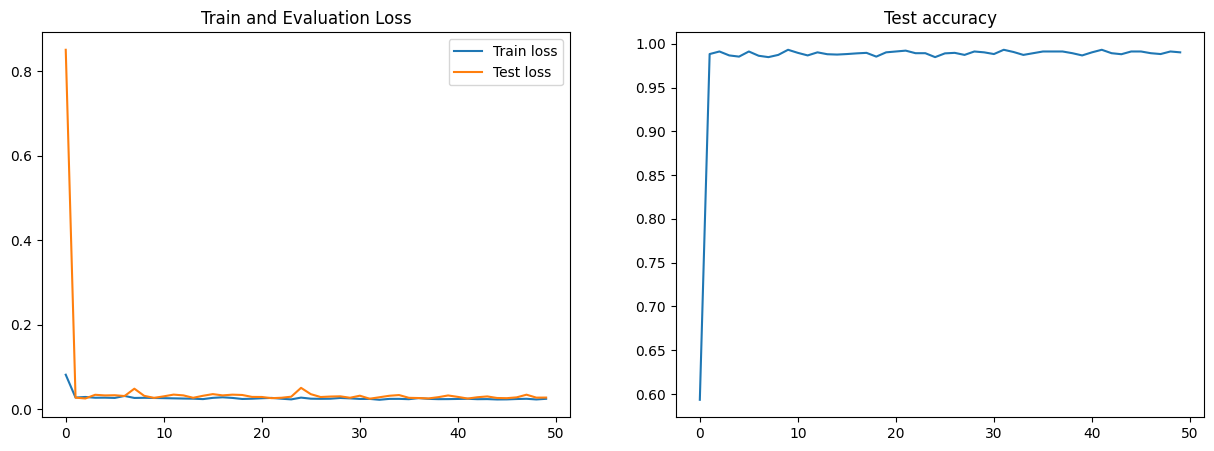

In [8]:
# Plot the training loss, test loss, and test accuracy with smoothing
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_losses, label='Train loss')
axs[0].plot(test_losses, label='Test loss')
axs[0].set_title('Train and Evaluation Loss')
axs[0].legend()
axs[1].plot(test_accuracies)
axs[1].set_title('Test accuracy')

For this task, we can see that the classifiation objective is actually very easy. The losses start out very small and the network is able to learn the correct decision boundary quickly. As a result, the training loss converges to zero almost instantly and the test loss fluctuates around a constant near-zero values throughout the training process. Similarly, the test accuract starts out very high, and once the model has trained for only a few iterations, the accuracy converges to its 99%+ success rate. 

We can now observe the decision boundaries for each neuron in the network. Given that each neuron is activated via a ReLU function, the boundaries correspond to areas in which $relu(x) > 0$ is active, and otherwise inactive.

Text(0.5, 1.0, 'Decision boundaries on the Evaluation Data')

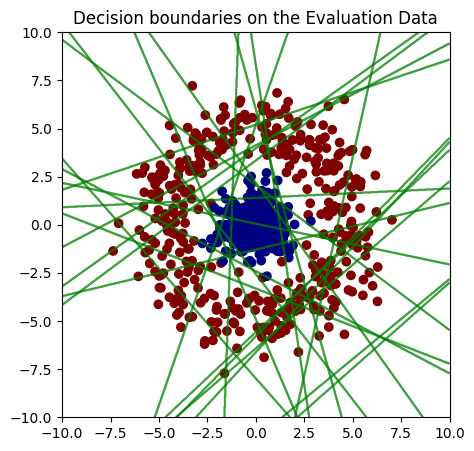

In [9]:
# Configure an input space
x_min, x_max = -10, 10
x1 = np.linspace(x_min, x_max, 1000)
x2 = np.linspace(x_min, x_max, 1000)
x1, x2 = np.meshgrid(x1, x2)

# Get the weights and biases from the model
weights = model.fc1.weight.data.numpy()
biases = model.fc1.bias.data.numpy()

y_s = []
# Plot the decision boundaries for each weight/bias pair
for i in range(weights.shape[0]):
    y = weights[i][0] * x1 + weights[i][1] * x2 + biases[i]

    # Make y a tensor
    y = torch.from_numpy(y)
    
    # Binarize y
    y[y >= 0] = 1
    y[y < 0] = 0

    y_s.append(y)

# Superimpose the decision boundaries on the data
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(testx[:, 0], testx[:, 1], c=testy, cmap='jet')
for y in y_s:
    ax.contour(x1, x2, y, levels=1, colors='green', alpha=0.5)
ax.set_title('Decision boundaries on the Evaluation Data')